In [1]:
%load_ext autoreload
%autoreload 2

from funcs import *
import geopandas as gpd
import pandas as pd
import numpy as np
from api import get_data
import json

import contextily as cx

from libpysal import weights
import matplotlib.pyplot as plt
import networkx as nx

'''fips_df = pd.read_csv("state_and_county_fips_master.csv")
fips_df = fips_df[fips_df["state"].isin(["MD", "DC", "VA"])]
fips_df["code"] = fips_df["fips"].apply(lambda a: str(a)[-3:])
dc_codes = fips_df[fips_df["name"].isin(["District of Columbia"])]["code"]
md_counties = ["Prince George's County", "Montgomery County"]
va_counties = ["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city"]
md_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(md_counties)]["code"] # , "Anne Arundel County", "Howard County", "Baltimore County", "Baltimore city"
va_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(va_counties)]["code"] # , "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"'''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'fips_df = pd.read_csv("state_and_county_fips_master.csv")\nfips_df = fips_df[fips_df["state"].isin(["MD", "DC", "VA"])]\nfips_df["code"] = fips_df["fips"].apply(lambda a: str(a)[-3:])\ndc_codes = fips_df[fips_df["name"].isin(["District of Columbia"])]["code"]\nmd_counties = ["Prince George\'s County", "Montgomery County"]\nva_counties = ["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city"]\nmd_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(md_counties)]["code"] # , "Anne Arundel County", "Howard County", "Baltimore County", "Baltimore city"\nva_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(va_counties)]["code"] # , "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"'

In [2]:
dcs_df = gpd.GeoDataFrame.from_file("data/real_transit/DC_Streetcar_Routes.shp").to_crs("EPSG:4326")
dcs_df.color = 'brown'
marc_df = gpd.GeoDataFrame.from_file("data/real_transit/Maryland_Transit_-_MARC_Train_Lines.shp").to_crs("EPSG:4326")
marc_df["color"] = marc_df["Rail_Name"].apply(lambda a: '#EFAD1D' if 'Brunswick' in a else '#F15828' if 'Camden' in a else '#C71F3E')
wmata_df = gpd.GeoDataFrame.from_file("data/real_transit/Metro_Lines_Regional.shp").to_crs("EPSG:4326")
wmata_df["color"] = wmata_df["NAME"].apply(lambda a: 
    '#F9921D' if 'orange' in a else 
    '#A1A3A1' if 'silver' in a else 
    '#E41838' if 'red' in a else
    '#FED201' if 'yellow' in a else
    '#01A850' if 'green' in a else
   '#0077C1')
vre_df = gpd.GeoDataFrame.from_file("data/real_transit/Virginia_Railway_Express_Routes.shp").to_crs("EPSG:4326")
vre_df["color"] = vre_df["RAILWAY_NM"].apply(lambda a: 
    '#156DB4' if 'Manassas' in a else 
    '#DD3534')
pl_df = gpd.GeoDataFrame.from_file("data/real_transit/PurpleLineAlignment.shp").to_crs("EPSG:4326")
pl_df["color"] = "#793390"

In [3]:
'''md_df = gpd.read_file("data/md/tl_2023_24_tabblock20.shp")
md_df = md_df[md_df["COUNTYFP20"].isin(md_codes.to_list())]
va_df = gpd.read_file("data/va/tl_2023_51_tabblock20.shp")
va_df = va_df[va_df["COUNTYFP20"].isin(va_codes.to_list())]
'''
dc_df = gpd.read_file("data/dc/tl_2023_11_tabblock20.shp")
'''
df = pd.concat([md_df, va_df, dc_df])
df.index = np.arange(df.shape[0])
df = gpd.GeoDataFrame(df)'''

'\ndf = pd.concat([md_df, va_df, dc_df])\ndf.index = np.arange(df.shape[0])\ndf = gpd.GeoDataFrame(df)'

In [4]:
'''
df.to_crs("EPSG:4326",inplace=True)
df["SID"] = df.index
df["INTPTLON20"] = df["INTPTLON20"].apply(lambda a: float(a))
df["INTPTLAT20"] = df["INTPTLAT20"].apply(lambda a: float(a))
# add NEIGHBORS column
df["NEIGHBORS"] = None
df["transit_potential"] = np.log(df['POP20']/(df['ALAND20'] + df['AWATER20'])*1000 + 1)
df.to_file("data/complete_region_df.geojson", driver="GeoJSON")'''

df = gpd.GeoDataFrame.from_file("data/complete_region_df.geojson")
extremities = [df["INTPTLON20"].min(), df["INTPTLAT20"].min(), df["INTPTLON20"].max(), df["INTPTLAT20"].max()]
extremities_dc = [dc_df["INTPTLON20"].min(), dc_df["INTPTLAT20"].min(), dc_df["INTPTLON20"].max(), dc_df["INTPTLAT20"].max()]
df_map = df.to_crs(epsg=3857)
ex_map = [df_map.centroid.x.min(),df_map.centroid.y.min(),df_map.centroid.x.max(),df_map.centroid.y.max()]
df_map_dc = dc_df.to_crs(epsg=3857)
ex_map_dc = [df_map_dc.centroid.x.min(),df_map_dc.centroid.y.min(),df_map_dc.centroid.x.max(),df_map_dc.centroid.y.max()]

In [5]:
#df["point_likelihood"] = df["transit_potential"]
#l = list(set(get_points(df, extremities)))
#points = gpd.GeoDataFrame(df[df['SID'].isin(l)])
#points.to_file("data/graph_points.geojson", driver="GeoJSON")
points = gpd.GeoDataFrame.from_file("data/graph_points.geojson")
combined_df_dc = gpd.GeoDataFrame.from_file("data/dc/non-population-points/combined_df.geojson")
combined_df_dc.reset_index(inplace=True, drop=True)
combined_df_md = gpd.GeoDataFrame.from_file("data/md/non-population-points/combined_df.geojson")
combined_df_md.reset_index(inplace=True, drop=True)
points = pd.concat([points, combined_df_dc, combined_df_md])
points.reset_index(inplace=True)
points = points["geometry"]
df_points = gpd.GeoDataFrame(geometry=points.centroid)
df_points = df_points.drop_duplicates()
df_points.reset_index(inplace=True, drop=True)
#df_points = df_points.to_crs(3857)

C:\Users\srjnk\AppData\Local\Temp\ipykernel_15928\3279460579.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_points = gpd.GeoDataFrame(geometry=points.centroid)


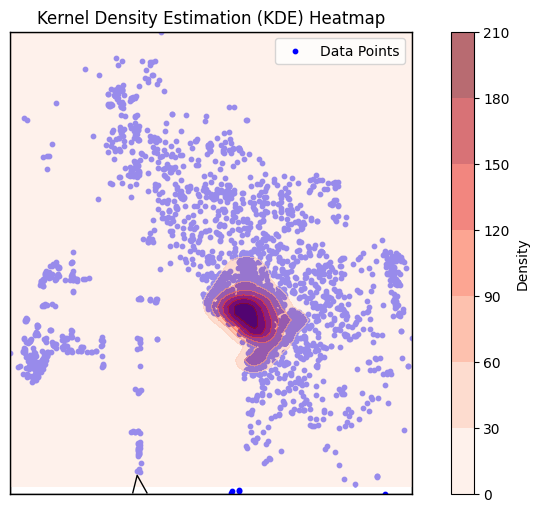

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap

# Assuming df_points is your GeoDataFrame containing point geometries
coords = np.vstack([(geom.xy[1][0], geom.xy[0][0]) for geom in df_points.geometry])

# Compute KDE
kde = KernelDensity(bandwidth=0.01, metric='haversine', kernel='gaussian', algorithm='ball_tree')
kde.fit(coords)

# Define grid for density estimation
lat_min, lon_min = coords.min(axis=0)
lat_max, lon_max = coords.max(axis=0)
lat_grid, lon_grid = np.meshgrid(np.linspace(lat_min, lat_max, 70), np.linspace(lon_min, lon_max, 70))
grid_coords = np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T

# Compute density estimates
log_dens = kde.score_samples(grid_coords)
density = np.exp(log_dens).reshape(70,70)

# Plot results
plt.figure(figsize=(10, 6))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.scatter(coords[:, 1], coords[:, 0], latlon=True, c='blue', s=10, label='Data Points')
m.contourf(lon_grid, lat_grid, density, latlon=True, cmap='Reds', alpha=0.6)
plt.colorbar(label='Density')
plt.title('Kernel Density Estimation (KDE) Heatmap')
plt.legend()
plt.show()


In [16]:
pts_array = np.array(list(zip(df_points.geometry.x, df_points.geometry.y)))
gabriel = weights.Gabriel.from_dataframe(df_points, use_index=True,silence_warnings=True)
gabriel_contracted, new_positions = contract_louvain_communities_with_positions(
    gabriel.to_networkx(), 
    {n: pts_array[n] for n in gabriel.to_networkx().nodes()}, 
    5
)
assign_edge_weights(gabriel_contracted, new_positions)
mst_contracted = reduce_degree(gabriel_contracted, new_positions, 4, 30)#nx.algorithms.tree.mst.minimum_spanning_tree(gabriel_contracted)
#coordinates = np.column_stack((df_points.geometry.x, df_points.geometry.y))
#positions = dict(zip(mst.nodes, coordinates))

c:\Users\srjnk\Documents\metro_project\venv\Lib\site-packages\libpysal\weights\gabriel.py:145: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  return cls(point_array, ids=ids, **kwargs)


In [44]:
'''import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO

class TransitNetworkEnv(gym.Env):
    def __init__(self, G, locations, kde):
        super(TransitNetworkEnv, self).__init__()
        self.G = G
        self.locations = locations
        self.kde = kde
        self.action_space = spaces.Discrete(len(G.edges))
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(G.nodes), 2), dtype=np.float32)
        self.state = np.array([locations[node] for node in G.nodes])

    def reset(self):
        self.state = np.array([self.locations[node] for node in self.G.nodes])
        return self.state

    def step(self, action):
        edge = list(self.G.edges)[action]
        reward = self.calculate_reward(edge)
        done = False  # Define your termination condition
        return self.state, reward, done, {}

    def calculate_reward(self, edge):
        lat1, lon1 = self.locations[edge[0]]
        lat2, lon2 = self.locations[edge[1]]
        potential1 = self.kde.score_samples(np.array([[lat1,lon1]]))[0]
        potential2 = self.kde.score_samples(np.array([[lat2,lon2]]))[0]
        return potential1 + potential2

# Create environment
env = TransitNetworkEnv(mst_contracted, new_positions, kde)

# Train RL model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10)'''
import geopandas as gpd
import numpy as np
from scipy.stats import gaussian_kde

# Assume gdf is your GeoDataFrame with Point objects

# Extract latitude and longitude
points = np.vstack([(geom.xy[1][0], geom.xy[0][0]) for geom in df_points.geometry])

# Compute the KDE
kde = gaussian_kde(points.T)

# Function to estimate transit potential at any geographical point
def transit_potential(lat, lon):
    return kde([lat, lon])[0]

# Example usage
lat, lon = 38.8951, -77.0364  # Washington, D.C. coordinates
potential = transit_potential(lat, lon)
print(f"Transit potential at ({lat}, {lon}): {potential}")
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=2, out_channels=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Convert your graph to PyTorch Geometric data format
edge_index = torch.tensor(list(mst_contracted.edges)).t().contiguous()
x = torch.tensor([new_positions[node] for node in mst_contracted.nodes], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)

model = GCN()
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO

class TransitNetworkEnv(gym.Env):
    def __init__(self, G, locations, kde):
        super(TransitNetworkEnv, self).__init__()
        self.G = G
        self.locations = locations
        self.kde = kde
        self.action_space = spaces.Discrete(len(G.edges))
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(G.nodes), 2), dtype=np.float32)
        self.state = np.array([locations[node] for node in G.nodes])

    def reset(self):
        self.state = np.array([self.locations[node] for node in self.G.nodes])
        return self.state

    def step(self, action):
        edge = list(self.G.edges)[action]
        reward = self.calculate_reward(edge)
        done = False  # Define your termination condition
        return self.state, reward, done, {}

    def calculate_reward(self, edge):
        lat1, lon1 = self.locations[edge[0]]
        lat2, lon2 = self.locations[edge[1]]
        potential1 = self.kde([lat1, lon1])[0]
        potential2 = self.kde([lat2, lon2])[0]
        return potential1 + potential2

# Create environment
env = TransitNetworkEnv(mst_contracted, new_positions, kde)

# Train RL model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

Transit potential at (38.8951, -77.0364): 53.039635167188344
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\srjnk\Documents\metro_project\venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 178  |
|    iterations      | 1    |
|    time_elapsed    | 11   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.023901995 |
|    clip_fraction        | 0.406       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.19       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0391     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 0.000531    |
-----------------------------------------
----------------------------------

KeyboardInterrupt: 

In [ ]:
model.
#lines = perform_walks(mst_contracted, new_positions, num_walks=12, max_distance=200000)

NetworkXError: Node tensor([115204.7969], grad_fn=<UnbindBackward0>) has no position.

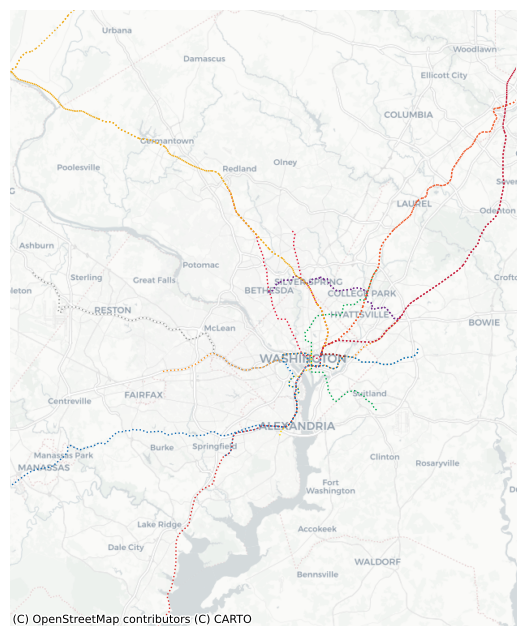

In [ ]:
#ax = df.plot(edgecolor='grey', facecolor='w', figsize=(8,8), linewidth=0.1)
ax = wmata_df.to_crs(epsg=3857).plot(figsize=(8,8), color=wmata_df.color, linestyle='dotted', linewidth=1)
ax = pl_df.to_crs(epsg=3857).plot(ax=ax, color=pl_df.color, linestyle='dotted', linewidth=1)
ax = marc_df.to_crs(epsg=3857).plot(ax=ax, color=marc_df.color, linestyle='dotted', linewidth=1)
ax = vre_df.to_crs(epsg=3857).plot(ax=ax, color=vre_df.color, linestyle='dotted', linewidth=1)
ax = dcs_df.to_crs(epsg=3857).plot(ax=ax, color=dcs_df.color, linestyle='dotted', linewidth=1)
#f,ax = mst.plot(df.to_crs(epsg=3857), ax=ax,
#        edge_kws=dict(color='r', linewidth=1.2),
#        node_kws=dict(marker=''))
ax.set_xlim([ex_map[0],ex_map[2]])
ax.set_ylim([ex_map[1],ex_map[3]])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax = nx.draw(mst_contracted, new_positions, ax=ax, node_size=5, node_color="b", edge_color="black")
#ax = plot_walks(mst_contracted, new_positions, lines, ax)
#ax = df_points.plot(ax=ax, color='black', marker='*', zorder=100)
plt.savefig("network_map_mst")

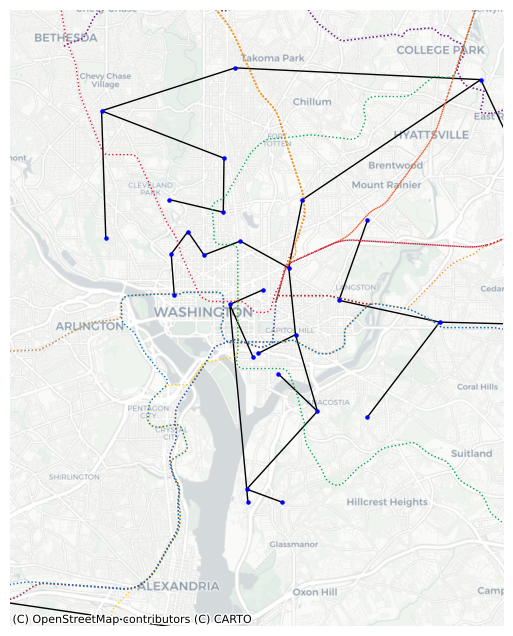

In [ ]:
ax = wmata_df.to_crs(epsg=3857).plot(figsize=(8,8), color=wmata_df.color, linestyle='dotted', linewidth=1)
ax = pl_df.to_crs(epsg=3857).plot(ax=ax, color=pl_df.color, linestyle='dotted', linewidth=1)
ax = marc_df.to_crs(epsg=3857).plot(ax=ax, color=marc_df.color, linestyle='dotted', linewidth=1)
ax = vre_df.to_crs(epsg=3857).plot(ax=ax, color=vre_df.color, linestyle='dotted', linewidth=1)
ax = dcs_df.to_crs(epsg=3857).plot(ax=ax, color=dcs_df.color, linestyle='dotted', linewidth=1)
#f,ax = mst.plot(df.to_crs(epsg=3857), ax=ax,
#        edge_kws=dict(color='r', linewidth=1.2),
#        node_kws=dict(marker=''))
#ax = df_points.plot(ax=ax, color='black', marker='*', zorder=100)
ax.set_xlim([ex_map_dc[0],ex_map_dc[2]])
ax.set_ylim([ex_map_dc[1],ex_map_dc[3]])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax = nx.draw(mst_contracted, new_positions, ax=ax, node_size=5, node_color="b", edge_color="black")
#ax = plot_walks(mst_contracted, new_positions, lines, ax)
plt.savefig("network_map_dc_mst")

In [ ]:
'''url_prefix = "https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/"
url_suffix = "" + url_suffix
url = url_prefix + "Health_WebMercator/MapServer/4" + url_suffix
hospital_df = get_data(url, 'hospital')
url = url_prefix + "Business_Goods_and_Service_WebMercator/MapServer/4" + url_suffix
grocery_df = get_data(url, 'grocery')
url = url_prefix + "Cultural_and_Society_WebMercator/MapServer/5" + url_suffix
religion_df = get_data(url, 'religion')
url = url_prefix + "Cultural_and_Society_WebMercator/MapServer/4" + url_suffix
library_df = get_data(url, 'library')
url = url_prefix + "Location_WebMercator/FeatureServer/3" + url_suffix
poi_df = get_data(url, 'poi')
url = url_prefix + "Education_WebMercator/MapServer/5" + url_suffix
pub_school_df = get_data(url, 'pub_school')
url = url_prefix + "Education_WebMercator/MapServer/3" + url_suffix
ind_school_df = get_data(url, 'ind_school')
url = url_prefix + "Recreation_WebMercator/MapServer/3" + url_suffix
rec_df = get_data(url, 'rec')
url = url_prefix + "Cultural_and_Society_WebMercator/MapServer/54" + url_suffix
museum_df = get_data(url, 'museum')
url = url_prefix + "Cultural_and_Society_WebMercator/MapServer/6" + url_suffix
unknown_df = get_data(url, 'unknown')
url = url_prefix + "Health_WebMercator/MapServer/7" + url_suffix
primary_care_df = get_data(url, 'primary_care')
url = url_prefix + "Public_Service_WebMercator/MapServer/55" + url_suffix
wic_df = get_data(url, 'wic')
url = url_prefix + "Business_Goods_and_Service_WebMercator/MapServer/9" + url_suffix
pharm_df = get_data(url, 'pharm')'''
url_prefix = "https://geodata.md.gov/imap/rest/services/"
url_suffix = "/query?where=1%3D1&outFields=*&outSR=4326&f=json"
url = url_prefix + "Structure/MD_StateFacilities/FeatureServer/0" + url_suffix
state_facilities_df = get_data(url, 'state_facilities', 'md')
url = url_prefix + "Military/MD_MilitaryInstallations/FeatureServer/0" + url_suffix
fed_mil_df = get_data(url, 'fed_mil', 'md')
url = url_prefix + "Military/MD_MilitaryInstallations/FeatureServer/1" + url_suffix
state_mil_df = get_data(url, 'state_mil', 'md')
url = url_prefix + "Structure/MD_CommunitySupport/FeatureServer/0" + url_suffix
gov_support_df = get_data(url, 'gov_support', 'md')
url = url_prefix + "BusinessEconomy/MD_IncentiveZones/FeatureServer/11" + url_suffix
incentive_zones_df = get_data(url, 'incentive_zones', 'md')
url = url_prefix + "BusinessEconomy/MD_IncentiveZones/FeatureServer/1" + url_suffix
main_street_df = get_data(url, 'main_street', 'md')
url = url_prefix + "Education/MD_Libraries/FeatureServer/0" + url_suffix
libraries_df = get_data(url, 'libraries', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/2" + url_suffix
fy_priv_df = get_data(url, 'fy_priv', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/5" + url_suffix
k12_public_df = get_data(url, 'k12_public', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/6" + url_suffix
k12_charter_df = get_data(url, 'k12_charter', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/4" + url_suffix
higher_ed_df = get_data(url, 'higher_ed', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/1" + url_suffix
ty_public_df = get_data(url, 'ty_public', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/0" + url_suffix
fy_public_df = get_data(url, 'fy_public', 'md')
url = url_prefix + "Education/MD_EducationFacilities/FeatureServer/3" + url_suffix
ty_private_df = get_data(url, 'ty_private', 'md')
url = url_prefix + "Health/MD_LongTermCareAssistedLiving/FeatureServer/1" + url_suffix
assisted_df = get_data(url, 'assisted', 'md')
url = url_prefix + "Health/MD_Hospitals/FeatureServer/0" + url_suffix
hospital_df = get_data(url, 'hospital', 'md')
url = url_prefix + "Historic/MD_NationalRegisterHistoricPlaces/FeatureServer/0" + url_suffix
nrhp_df = get_data(url, 'nrhp', 'md')
url = url_prefix + "BusinessEconomy/MD_IncentiveZones/FeatureServer/12" + url_suffix
arts_df = get_data(url, 'arts', 'md')

In [ ]:
arts_df["attributes"].apply(lambda a: a['county'])

0            Worcester
1           Montgomery
2           Dorchester
3         Anne Arundel
4             Allegany
5            Frederick
6                Cecil
7      Prince George's
8           Washington
9              Harford
10      Baltimore City
11            Allegany
12            Wicomico
13          Montgomery
14           Worcester
15      Baltimore City
16          Montgomery
17             Harford
18      Baltimore City
19        Queen Anne's
20          St. Mary's
21                Kent
22             Garrett
23             Garrett
24            Caroline
25            Somerset
26              Talbot
27      Baltimore City
28    Baltimore County
Name: attributes, dtype: object

In [ ]:
'''combined_df = pd.concat([hospital_df, grocery_df, religion_df, library_df, poi_df, pub_school_df, ind_school_df, rec_df, museum_df, unknown_df, primary_care_df, wic_df, pharm_df])
combined_df.reset_index(inplace=True, drop=True)
combined_df.to_file("data/dc/non-population-points/combined_df.geojson", driver="GeoJSON")'''
import re
combined_df = pd.concat([state_facilities_df, fed_mil_df, state_mil_df, gov_support_df, incentive_zones_df, main_street_df, libraries_df, fy_priv_df, k12_public_df, k12_charter_df, higher_ed_df, ty_public_df, fy_public_df, ty_private_df, assisted_df, hospital_df, nrhp_df])
def converter(a):
    if type(a) == dict:
        if 'county' in a:
            return a['county'].strip().lower()
        elif "County" in a:
            return a['County'].strip().lower()
        else:
            return 'baltimore city'
    else:
        try:
            return converter(dict(a))
        except:
            try:
                return converter(json.loads(a))
            except:
                matches = re.finditer(r'county[\'"] ?:', a.lower())
                for match in matches:
                    search_area = a.lower()[match.end():match.end()+50].strip()
                    m = re.findall(r'[\'"]([a-z \']+)[\'"]', search_area)
                    if m and m[0]:
                        return m[0]
                return 'UNK'
combined_df["county"] = combined_df["attributes"].apply(converter)
combined_df = combined_df[combined_df["county"].apply(lambda a: 'george' in a or 'montgom' in a)]
combined_df.reset_index(inplace=True, drop=True)
combined_df.to_file("data/md/non-population-points/combined_df.geojson", driver="GeoJSON")
combined_df = gpd.GeoDataFrame.from_file("data/dc/non-population-points/combined_df.geojson")
combined_df

,attributes,geometry
0,{'NAME': 'MedStar National Rehabilitation Hosp...,POINT (-77.01335 38.93055)
1,"{'NAME': ""Children's National Medical Center (...",POINT (-77.0144 38.92727)
2,"{'NAME': 'United Medical Center (Acute Care)',...",POINT (-76.98475 38.83603)
3,{'NAME': 'BridgePoint Hospital Capitol Hill (L...,POINT (-76.99583 38.89308)
4,{'NAME': 'Howard University Hospital (Acute Ca...,POINT (-77.0201 38.91756)
...,...,...
3732,"{'NAME': 'MORTON 8TH ST. PHARMACY', 'LICENSE_N...",POINT (-76.99518 38.89006)
3733,"{'NAME': 'GOODCARE PHARMACY', 'LICENSE_NUMBER'...",POINT (-76.99657 38.8457)
3734,"{'NAME': ""GRUBB'S PHARMACY SE INC"", 'LICENSE_N...",POINT (-76.98806 38.86758)
3735,"{'NAME': 'HARRIS TEETER #352', 'LICENSE_NUMBER...",POINT (-77.00561 38.90594)
